In [1]:
import os
import configparser
from collections.abc import Iterable
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
import logging
from mne.viz import plot_topomap
from meegnet_functions import load_single_subject
from meegnet.parsing import parser, save_config
from meegnet.network import Model
from meegnet.viz import load_info


LOG = logging.getLogger("meegnet")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
)

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#########################
### HARD CODED VALUES ###
#########################

LABELS = ["visual", "auditory"]  # image is label 0 and sound label 1
CHANNELS = ("GRAD", "GRAD2", "MAG")

In [3]:
###############
### PARSING ###
###############

# For Jupyter Notebook Only: we create fake args
argstring = "--config ../scripts/eventclf.ini".split()
args = parser.parse_args(argstring)
save_config(vars(args), args.config)
default_values = configparser.ConfigParser()
default_values.read("../default_values.ini")
default_values = default_values["config"]

fold = None if args.fold == -1 else int(args.fold)
if args.clf_type == "eventclf":
    assert (
        args.datatype != "rest"
    ), "datatype must be set to passive in order to run event classification"

if args.feature == "bins":
    trial_length = default_values["TRIAL_LENGTH_BINS"]
elif args.feature == "bands":
    trial_length = default_values["TRIAL_LENGTH_BANDS"]
elif args.feature == "temporal":
    trial_length = default_values["TRIAL_LENGTH_TIME"]

if args.clf_type == "subclf":
    trial_length = int(args.segment_length * args.sfreq)

if args.sensors == "MAG":
    n_channels = default_values["N_CHANNELS_MAG"]
elif args.sensors == "GRAD":
    n_channels = default_values["N_CHANNELS_GRAD"]
else:
    n_channels = default_values["N_CHANNELS_OTHER"]

input_size = (
    (1, n_channels, trial_length)
    if args.flat
    else (
        n_channels // default_values["N_CHANNELS_MAG"],
        default_values["N_CHANNELS_MAG"],
        trial_length,
    )
)

name = f"{args.clf_type}_{args.model_name}_{args.seed}_{args.sensors}"
suffixes = ""
if args.net_option == "custom_net":
    if args.batchnorm:
        suffixes += "_BN"
    if args.maxpool != 0:
        suffixes += f"_maxpool{args.maxpool}"

    name += f"_dropout{args.dropout}_filter{args.filters}_nchan{args.nchan}_lin{args.linear}_depth{args.hlayers}"
    name += suffixes

n_samples = None if int(args.n_samples) == -1 else int(args.n_samples)
if args.clf_type == "subclf":
    data_path = os.path.join(args.save_path, f"downsampled_{args.sfreq}")
    n_subjects = len(os.listdir(data_path))
    n_outputs = min(n_subjects, args.max_subj)
    lso = False
else:
    n_outputs = 2
    lso = True

In [4]:
######################
### LOGGING CONFIG ###
######################

if args.log:
    log_name = f"{args.model_name}_{args.seed}_{args.sensors}"
    if fold is not None:
        log_name += f"_fold{args.fold}"
    log_name += "_filter_computations.log"
    log_file = os.path.join(args.save_path, log_name)
    logging.basicConfig(filename=log_file, filemode="a")
    LOG.info(f"Starting logging in {log_file}")

07/16/2024 12:11:37 PM Starting logging in /home/arthur/data/meegnet_42_ALL_filter_computations.log


In [5]:
##############################
### PREPARING SAVE FOLDERS ###
##############################

viz_path = os.path.join(args.save_path, "visualizations")
if not os.path.exists(viz_path):
    os.makedirs(viz_path)

netviz_path = os.path.join(viz_path, name)
if not os.path.exists(netviz_path):
    os.makedirs(netviz_path)

In [6]:
#####################
### LOADING MODEL ###
#####################

if args.model_path is None:
    model_path = args.save_path
else:
    model_path = args.model_path

if not os.path.exists(model_path):
    logging.info(f"{model_path} does not exist. Creating folders")
    os.makedirs(model_path)

my_model = Model(name, args.net_option, input_size, n_outputs, save_path=args.save_path)
my_model.from_pretrained()
# my_model.load()

model_weights = my_model.feature_weights

07/16/2024 12:11:37 PM None does not exist. Creating folders
07/16/2024 12:11:37 PM => loading checkpoint '/home/arthur/.cache/huggingface/hub/models--lamaroufle--meegnet/snapshots/5f96fe8d1b9ce85462329cdb3f148e83d3383873/eventclf_meegnet_3_102_400_2.pt'


Opening raw data file /home/arthur/data/camcan/cc700/meg/pipeline/release005/BIDSsep/derivatives_passive/aa/AA_movecomp_transdef/aamod_meg_maxfilt_00003/sub-CC610210/mf2pt2_sub-CC610210_ses-passive_task-passive_megtransdef.fif...
    Range : 44000 ... 190999 =     44.000 ...   190.999 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/meegnet/viz.py:929: RuntimeWarning: This filename (/home/arthur/data/camcan/cc700/meg/pipeline/release005/BIDSsep/derivatives_passive/aa/AA_movecomp_transdef/aamod_meg_maxfilt_00003/sub-CC610210/mf2pt2_sub-CC610210_ses-passive_task-passive_megtransdef.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(subj_path, file), preload=False)
/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/mne/viz/topomap.py:1020: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplo

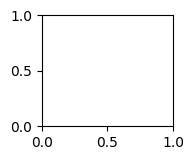

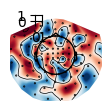

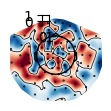

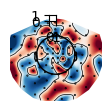

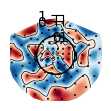

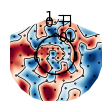

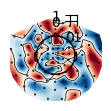

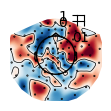

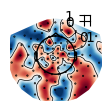

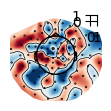

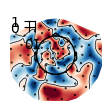

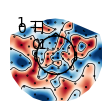

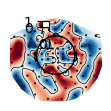

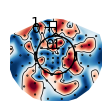

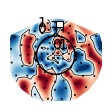

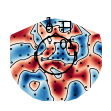

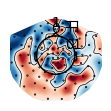

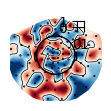

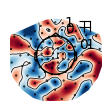

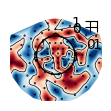

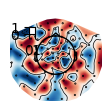

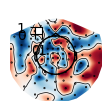

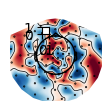

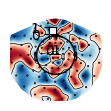

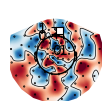

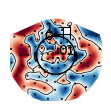

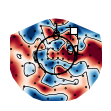

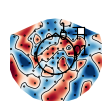

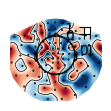

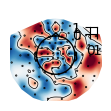

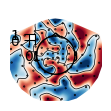

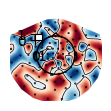

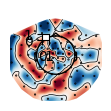

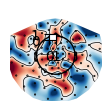

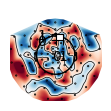

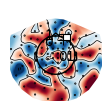

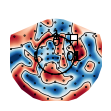

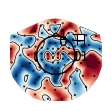

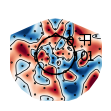

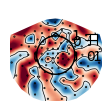

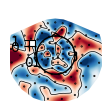

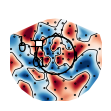

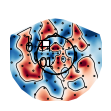

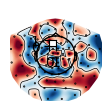

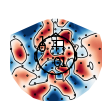

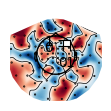

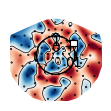

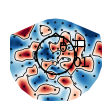

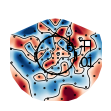

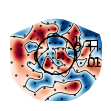

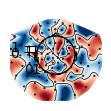

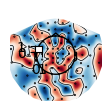

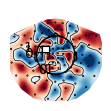

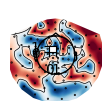

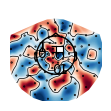

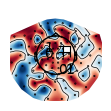

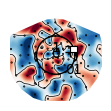

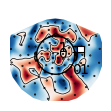

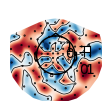

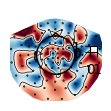

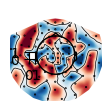

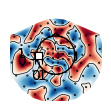

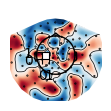

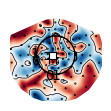

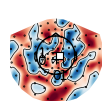

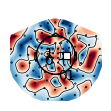

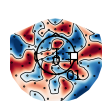

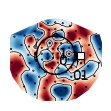

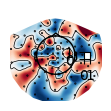

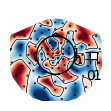

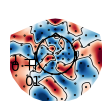

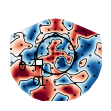

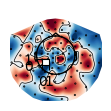

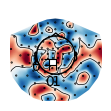

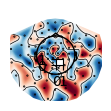

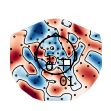

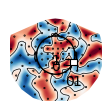

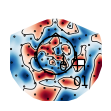

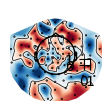

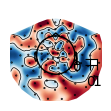

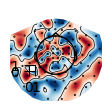

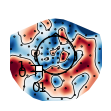

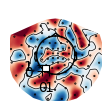

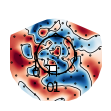

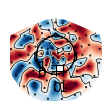

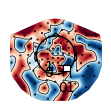

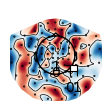

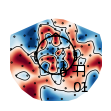

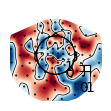

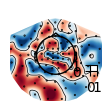

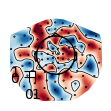

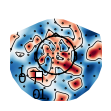

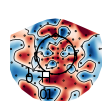

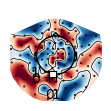

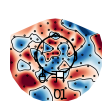

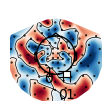

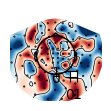

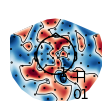

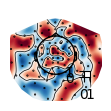

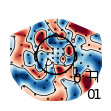

In [7]:
#############################################
### Genrating feature importance topomaps ###
#############################################

info = load_info(args.raw_path, args.datatype)

plt.figure(figsize=(20, 17))
for i, filtr in enumerate(model_weights[0]):
    plt.subplot(10, 10, i + 1)
    im, _ = plot_topomap(
        filtr[0, :, :].ravel(),
        info,
        res=128,
        show=False,
        contours=1,
        extrapolate="local",
    )
    plt.axis("off")
plt.savefig(os.path.join(viz_path, name, "filters.png"))
plt.close()

In [8]:
######################
### FILTER OUTPUTS ###
######################

dataframe = (
    pd.read_csv(
        os.path.join(args.save_path, f"participants_info.csv"),
        index_col=0,
    )
    .sample(frac=1, random_state=args.seed)
    .reset_index(drop=True)[: args.max_subj]
)
subj_list = dataframe["sub"]

# Incrementing and changing subject in case there is an error with loading subject data
data = []
while data == []:
    data = load_single_subject("random", n_samples, lso, args).data

input_tensor = data.to(torch.float).cpu()

np.random.seed(args.seed)
random_sample = input_tensor[np.random.choice(np.arange(len(input_tensor)))][np.newaxis, :]
random_sample = random_sample.cuda()

results = [my_model.net.feature_extraction[0](random_sample)]
for layer in my_model.net.feature_extraction[1:]:
    results.append(layer(results[-1]))
outputs = results

07/16/2024 12:11:48 PM Logging subjects and labels from /home/arthur/data...


In [21]:
#############################
### FILTER VISUALISATIONS ###
#############################

for layer_idx, out in enumerate(outputs):
    plt.figure(figsize=(30, 30))
    layer_viz = out[0].data.cpu()
    if len(layer_viz.shape) <= 1:
        continue
    for i, filt in enumerate(layer_viz):
        if i == 100:  # we will visualize only 10x10 blocks from each layer
            break
        plt.subplot(10, 10, i + 1)
        plt.plot(np.arange(len(filt[0])), filt[0])
    logging.info(f"Saving layer {layer_idx} feature maps...")
    plt.savefig(os.path.join(viz_path, name, f"layer_{layer_idx}.png"))
    plt.close()

07/16/2024 12:21:00 PM Saving layer 0 feature maps...
07/16/2024 12:21:03 PM Saving layer 1 feature maps...
07/16/2024 12:21:08 PM Saving layer 2 feature maps...
07/16/2024 12:21:12 PM Saving layer 3 feature maps...
07/16/2024 12:21:15 PM Saving layer 4 feature maps...
07/16/2024 12:21:17 PM Saving layer 5 feature maps...
07/16/2024 12:21:20 PM Saving layer 6 feature maps...
07/16/2024 12:21:23 PM Saving layer 7 feature maps...
07/16/2024 12:21:27 PM Saving layer 8 feature maps...
07/16/2024 12:21:30 PM Saving layer 9 feature maps...
07/16/2024 12:21:33 PM Saving layer 10 feature maps...


<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>